# Bank Customer Churn Prediction

### loading data

In [1]:
import pandas as pd

dataset = pd.read_csv("Bank Customer Churn Prediction.csv")

In [2]:
print("number of datapoints : {}\nnumber of features : {}".format(dataset.shape[0],dataset.shape[1]))

number of datapoints : 10000
number of features : 12


In [3]:
dataset.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### dropping customer_id

In [4]:
dataset = dataset.drop(columns ="customer_id")
dataset.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### checking categorical features

In [5]:
import numpy as np
print(np.unique(dataset.loc[:,"country"].to_numpy()))
print(np.unique(dataset.loc[:,"gender"].to_numpy()))

['France' 'Germany' 'Spain']
['Female' 'Male']


### one hot encoding

In [6]:
dataset = pd.get_dummies(dataset)
dataset.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [7]:
print("number of datapoints : {}\nnumber of features : {}".format(dataset.shape[0],dataset.shape[1]))

number of datapoints : 10000
number of features : 14


### turning dataframe into suitable array forms

In [8]:
labels = dataset.loc[:,"churn"].to_numpy()
dataset = dataset.drop(columns ="churn")
fetureNames = dataset.columns.to_numpy()
data = dataset.to_numpy()

print(labels)
print(fetureNames)
print(data)

[1 0 1 ... 1 1 0]
['credit_score' 'age' 'tenure' 'balance' 'products_number' 'credit_card'
 'active_member' 'estimated_salary' 'country_France' 'country_Germany'
 'country_Spain' 'gender_Female' 'gender_Male']
[[619.  42.   2. ...   0.   1.   0.]
 [608.  41.   1. ...   1.   1.   0.]
 [502.  42.   8. ...   0.   1.   0.]
 ...
 [709.  36.   7. ...   0.   1.   0.]
 [772.  42.   3. ...   0.   0.   1.]
 [792.  28.   4. ...   0.   1.   0.]]


### checking label counts

[7963 2037]


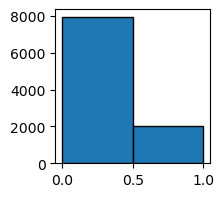

In [9]:
import matplotlib.pyplot as plt

print(np.bincount(labels))
plt.figure(figsize=(2,2))
plt.hist(labels,2,edgecolor = "black")
plt.show()

**data is imbalanced**

### trying a simple model ( logistic regression )

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data,labels,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
logreg_pred = logreg.predict(X_test)
testScore = logreg.score(X_test,Y_test)
trainScore = logreg.score(X_train,Y_train)
print("pure logisticRegression test score : {:.2f}".format(testScore*100))
print("pure logisticRegression train score : {:.2f}".format(trainScore*100))

pure logisticRegression test score : 78.76
pure logisticRegression train score : 79.09


**clearly underfitting (same test and train score)**<br>
i will tune hyperparameters later 

### trying a more complicated model (random forest)

In [11]:
from sklearn.ensemble import RandomForestClassifier

rForest = RandomForestClassifier()
rForest.fit(X_train,Y_train)
rForest_pred = rForest.predict(X_test)
score = rForest.score(X_test,Y_test)
print("pure random forest score : {:.2f}".format(score*100))

pure random forest score : 86.16


### checking confusion matrix 
data is imbalanced so it seems that we are being optimistic in log reg

In [12]:
from sklearn.metrics import confusion_matrix,f1_score

matrix = confusion_matrix(Y_test,logreg_pred)
print(matrix)
print("\nf1 score of the log reg : {:.2f}".format(f1_score(Y_test,logreg_pred)*100))

[[1940   51]
 [ 480   29]]

f1 score of the log reg : 9.85


too many FP and FN , very poor f1 score

### more analysing about being imbalanced

In [13]:
from sklearn.metrics import classification_report

print(classification_report(Y_test,logreg_pred,target_names=["not churn","churn"]))


              precision    recall  f1-score   support

   not churn       0.80      0.97      0.88      1991
       churn       0.36      0.06      0.10       509

    accuracy                           0.79      2500
   macro avg       0.58      0.52      0.49      2500
weighted avg       0.71      0.79      0.72      2500



predicting false not churn will have **very high impact** (some one hase been churned and we did not found out !)<br>
predicting false churn has lower impact. ( someone has not churned but we falsly predicted he that he does , it does not have very high business impact , just some adittional researches about customer will be done )<br>
so reducing false negatives is important for us , it means that **recall** is more important for us<br>
<br>
RECALL = TP/(TP+FN)
<br><br>
so i try to increase recall, recall is 6 percent as above report

### precission recall curve

log red closest to mid threshold : -0.002867356919858705
random forest closest to mid threshold : 0.5


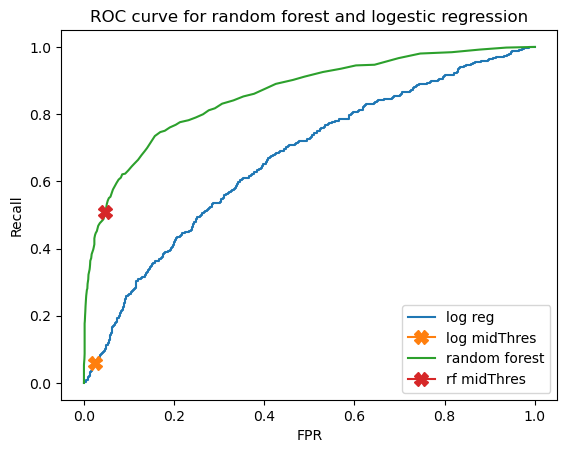

in log reg for mid threshold fpr is 2.56 and recall is 5.89
in random forest for mid threshold fpr is 4.62 and recall is 50.88


In [14]:
from sklearn.metrics import roc_curve

log_decesionFunc = logreg.decision_function(X_test)
forest_predictProba = rForest.predict_proba(X_test)[:,1]

fpr_log, recall_log, threshold_log = roc_curve(Y_test,log_decesionFunc)
fpr_rf, recall_rf, threshold_rf = roc_curve(Y_test,forest_predictProba)

midThres_log = np.argmin(np.abs(threshold_log)) # abs is for ignoring negative values / zero is middle in decision func
midThres_rf = np.argmin(np.abs(threshold_rf-0.5)) # abs is for ignoring negative values / 0.5 is middle in pred proba

print("log red closest to mid threshold :",threshold_log[midThres_log])
print("random forest closest to mid threshold :",threshold_rf[midThres_rf])

plt.plot(fpr_log,recall_log,label = "log reg")
plt.plot(fpr_log[midThres_log],recall_log[midThres_log],marker="X",markersize=10,label = "log midThres")
plt.plot(fpr_rf,recall_rf,label = "random forest")
plt.plot(fpr_rf[midThres_rf],recall_rf[midThres_rf],marker="X",markersize=10,label = "rf midThres")

plt.title("ROC curve for random forest and logestic regression")
plt.xlabel("FPR")
plt.ylabel("Recall")
plt.legend()
plt.show()
print("in log reg for mid threshold fpr is {:.2f} and recall is {:.2f}"
      .format(fpr_log[midThres_log]*100,recall_log[midThres_log]*100))
print("in random forest for mid threshold fpr is {:.2f} and recall is {:.2f}"
      .format(fpr_rf[midThres_rf]*100,recall_rf[midThres_rf]*100))

log reg is acting very bad , rand forest is acting better and is also not very slow like svm so i igonre log reg
<br>maybe with some feature engineering it act better but time complexity does not differ

checking auc too :

In [15]:
from sklearn.metrics import roc_auc_score

print("auc score for log reg :",roc_auc_score(Y_test,log_decesionFunc)*100)
print("auc score for rf :",roc_auc_score(Y_test,forest_predictProba)*100)

auc score for log reg : 66.56683957968028
auc score for rf : 85.95753582674095


now that we understood tree based models will perform well let's check auc for gradient boosting classifier too

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier().fit(X_train,Y_train)
gbc_decisionFunc = gbc.decision_function(X_test)
print("auc score for gbc :",roc_auc_score(Y_test,gbc_decisionFunc)*100)

auc score for gbc : 87.50872047988048


thats not so diffrent from random forest , i will choose random forest as it can be tunned better

from roc curve we understand that with a **lower** threshold we will get a better recall and a balanced FPR<br>
so i extend random forest estimator so it can predict with respect to threshold<br>
then i will use crossValidation and grid search to find best 

### customized random forest

In [69]:
from sklearn.base import BaseEstimator,ClassifierMixin

class CRF(BaseEstimator,ClassifierMixin):
    
    def __init__(self,thres=0.5): # adding threshold as a hyper parameter
        self.threshold = thres
        self.subEstimator = RandomForestClassifier()

    def fit(self,X,y):
        return self.subEstimator.fit(X,y)
        
    def predict(self,X): # with respect to pred proba
        pred_proba = self.subEstimator.predict_proba(X)[:,1]
        thresPred = pred_proba > self.threshold
        thresPred = thresPred.astype(int)
        return thresPred

    def score(self,X,y):
        return f1_score(y,self.predict(X))

    def get_params(self,deep): # used in grid search cv
#         if(deep):raise Exception("deep is not defined")
        return {"thres":self.threshold}

In [50]:
# testing
crf = CRF(thres = 0.5)
crf.fit(X_train,Y_train)
# results should be near each other
print("f1 for default random forest :",f1_score(Y_test,rForest_pred)*100)
print("f1 for custom random forest with thres 0.5 :",crf.score(X_test,Y_test)*100)
#crf.score will return f1score now (now it can be used with cv and ...)

f1 for default random forest : 59.4847775175644
f1 for custom random forest with thres 0.5 : 61.1904761904762


## visualizing the ROC curve again for finding a good threshold range 

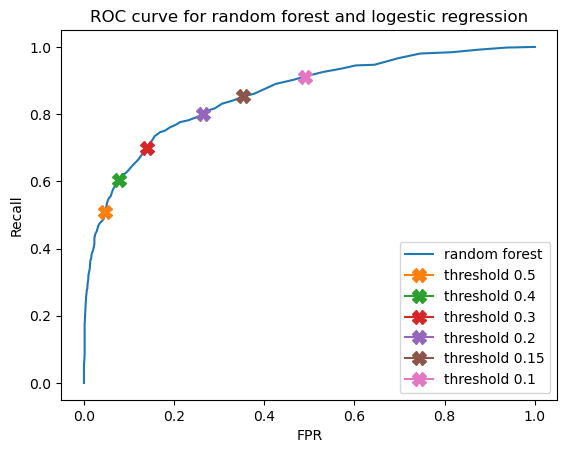

In [52]:
plt.plot(fpr_rf,recall_rf,label = "random forest")

for threshold in [0.5,0.4,0.3,0.2,0.15,0.1]:
    Thres = np.argmin(np.abs(threshold_rf-threshold))
    plt.plot(fpr_rf[Thres],recall_rf[Thres],marker="X",markersize=10,label = "threshold "+str(threshold))

plt.title("ROC curve for random forest and logestic regression")
plt.xlabel("FPR")
plt.ylabel("Recall")
plt.legend()
plt.show()

best threshold is between 0.4 & 0.1 

## finding best threshold

In [71]:
from sklearn.model_selection import GridSearchCV
grid_param = {'thres':[0.4,0.3,0.2,0.15,0.1]}
grid_search = GridSearchCV(CRF(),grid_param,cv=2)
grid_search.fit(X_train,Y_train)
print("best params",grid_search.best_params_)
print("best f1 score",grid_search.best_score_)

best params {'thres': 0.1}
best f1 score 0.557839808789891


In [ ]:
# todo : replace CRF score with recall